In [1]:
import os
import pickle

import pandas as pd

from nlp import pipeline_d2v, pipeline_lda
from processors import QueProc, StuProc, ProProc
from generator import BatchGenerator
from models import DistanceModel, SimpleModel, ConcatModel, Adam
from evaluation import permutation_importance, plot_fi
from utils import TextProcessor

pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None

DATA_PATH, SPLIT_DATE, TO_DUMP = '../../data/', '2019-01-01', True

tp = TextProcessor()

C:\Users\nikitosoleil\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# READ

In [2]:
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'), parse_dates=['answers_date_added'])
answers['answers_body'] = answers['answers_body'].apply(tp.process)
ans_train = answers[answers['answers_date_added'] < SPLIT_DATE]

questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'), parse_dates=['questions_date_added'])
questions['questions_title'] = questions['questions_title'].apply(tp.process)
questions['questions_body'] = questions['questions_body'].apply(tp.process)
questions['questions_whole'] = questions['questions_title'] + ' ' + questions['questions_body']
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]

professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'), parse_dates=['professionals_date_joined'])
professionals['professionals_headline'] = professionals['professionals_headline'].apply(tp.process)
professionals['professionals_industry'] = professionals['professionals_industry'].apply(tp.process)
pro_train = professionals[professionals['professionals_date_joined'] < SPLIT_DATE]

students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'), parse_dates=['students_date_joined'])
stu_train = students[students['students_date_joined'] < SPLIT_DATE]

tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv')) \
    .merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv')) \
    .merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

# TRAIN

In [10]:
# calculate and save tag and industry embeddings on train data
tag_embs, ind_embs, head_d2v, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, tag_pro, 10)
lda_dic, lda_tfidf, lda_model = pipeline_lda(que_train, 10)

if TO_DUMP:
    with open(r'..\..\d2v_lda.pkl', 'wb') as file:
        pickle.dump((tag_embs, ind_embs, head_d2v, ques_d2v, lda_dic, lda_tfidf, lda_model), file)

Index(['professionals_id', 'professionals_location', 'professionals_industry', 'professionals_headline', 'professionals_date_joined', 'tag_users_user_id', 'tags_pro_name'], dtype='object')
Index(['answers_id', 'answers_author_id', 'answers_question_id', 'answers_date_added', 'answers_body', 'questions_id', 'questions_author_id', 'questions_date_added', 'questions_title', 'questions_body', 'questions_whole', 'tag_questions_tag_id', 'tag_questions_question_id', 'tags_tag_id', 'tags_tag_name', 'professionals_id', 'professionals_location', 'professionals_industry', 'professionals_headline', 'professionals_date_joined', 'tag_users_user_id', 'tags_pro_name'], dtype='object')


In [13]:
# with open(r'..\..\d2v_lda.pkl', 'rb') as file:
#     tag_embs, ind_embs, head_d2v, ques_d2v, lda_dic, lda_tfidf, lda_model = pickle.load(file)

# extract and preprocess feature for all three main entities

pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(pro_train, que_train, ans_train, tag_pro)

que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(que_train, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(stu_train, que_train, ans_train)

# INGESTION

In [14]:
# construct dataframe used to extract positive pairs
pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# mappings from professional's id to his registration date. Used in batch generator
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in professionals.iterrows()}

bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

# MODEL

In [15]:
# in train mode, build, compile train and save model
model = DistanceModel(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2,
                      que_input_embs=[102, 42], que_output_embs=[2, 2],
                      pro_dim=len(pro_data.columns) - 2,
                      pro_input_embs=[102, 102, 42], pro_output_embs=[2, 2, 2],
                      inter_dim=20, output_dim=10)

for lr, epochs in zip([0.01, 0.001, 0.0001, 0.00001], [5, 10, 10, 5]):
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit_generator(bg, epochs=epochs, verbose=2)

Epoch 1/5
 - 12s - loss: 0.6135 - acc: 0.6920
Epoch 2/5
 - 8s - loss: 0.5605 - acc: 0.7240
Epoch 3/5
 - 8s - loss: 0.5580 - acc: 0.7243
Epoch 4/5
 - 10s - loss: 0.5583 - acc: 0.7232
Epoch 5/5
 - 8s - loss: 0.5550 - acc: 0.7276
Epoch 1/10
 - 9s - loss: 0.5265 - acc: 0.7475
Epoch 2/10
 - 11s - loss: 0.5213 - acc: 0.7516
Epoch 3/10
 - 8s - loss: 0.5197 - acc: 0.7527
Epoch 4/10
 - 8s - loss: 0.5184 - acc: 0.7557
Epoch 5/10
 - 9s - loss: 0.5148 - acc: 0.7582
Epoch 6/10
 - 8s - loss: 0.5143 - acc: 0.7574
Epoch 7/10
 - 8s - loss: 0.5129 - acc: 0.7599
Epoch 8/10
 - 8s - loss: 0.5122 - acc: 0.7608
Epoch 9/10
 - 8s - loss: 0.5084 - acc: 0.7643
Epoch 10/10
 - 8s - loss: 0.5099 - acc: 0.7626
Epoch 1/10
 - 8s - loss: 0.5059 - acc: 0.7648
Epoch 2/10
 - 8s - loss: 0.5048 - acc: 0.7654
Epoch 3/10
 - 8s - loss: 0.5036 - acc: 0.7670
Epoch 4/10
 - 8s - loss: 0.5037 - acc: 0.7664
Epoch 5/10
 - 8s - loss: 0.5026 - acc: 0.7685
Epoch 6/10
 - 8s - loss: 0.5037 - acc: 0.7682
Epoch 7/10
 - 8s - loss: 0.5015 - a

# EVALUATION

2048/2048 [==============================] - 0s 218us/step


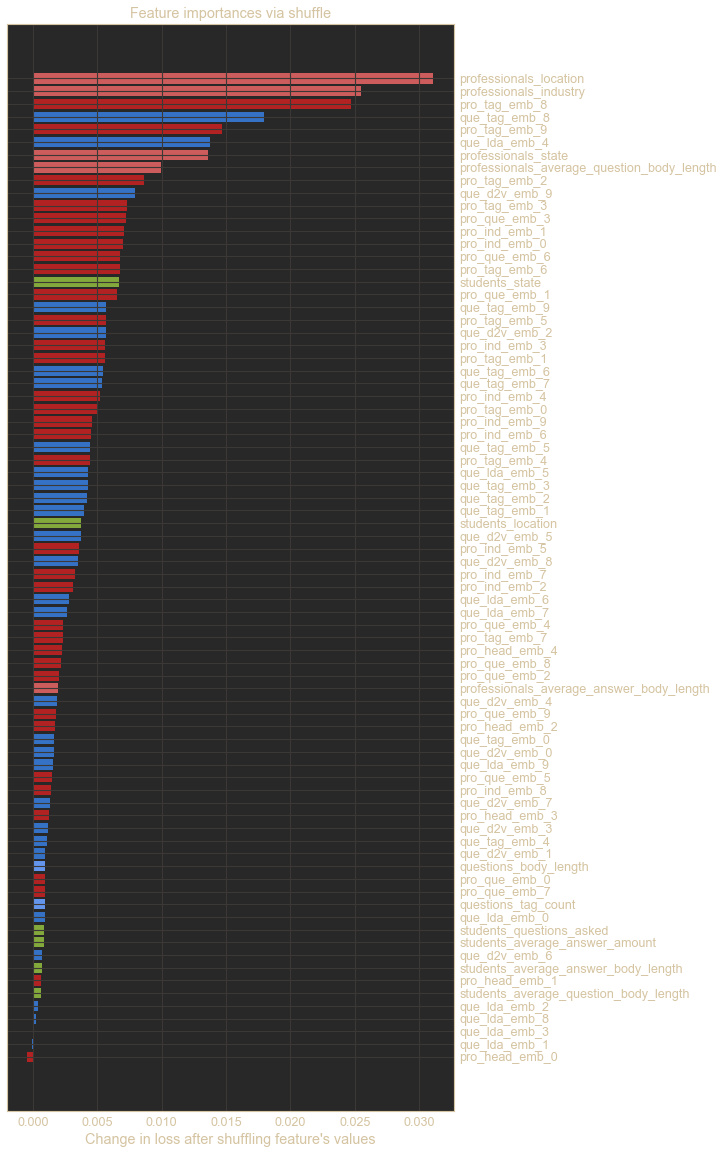

In [16]:
# dummy batch generator used to extract single big batch of data to calculate feature importance
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, pos_pairs, pro_to_date)

# dict with descriptions of feature names, used for visualization of feature importance
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

# calculate and plot feature importance
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

# TEST

In [17]:
# non-negative pairs are all known positive pairs to the moment
nonneg_pairs = pos_pairs

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] >= SPLIT_DATE].itertuples(index=False, name=None))
nonneg_pairs += pos_pairs

# extract and preprocess feature for all three main entities

que_proc = QueProc(tag_embs, ques_d2v, lda_dic, lda_tfidf, lda_model)
que_data = que_proc.transform(questions, tag_que)

stu_proc = StuProc()
stu_data = stu_proc.transform(students, questions, answers)

pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(professionals, questions, answers, tag_pro)

# initialize batch generator
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, nonneg_pairs, pro_to_date)

# EVALUATION

Loss: 0.4904789855846992, accuracy: 0.7932692307692307
1682/1682 [==============================] - 0s 196us/step


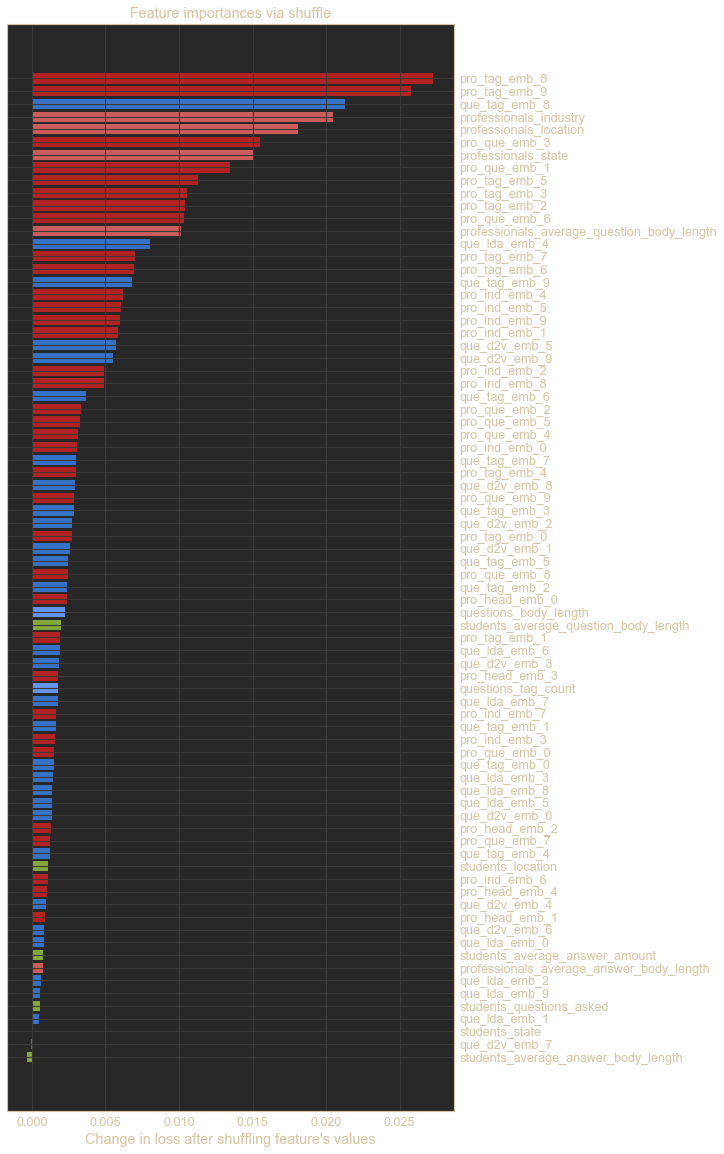

In [18]:
loss, acc = model.evaluate_generator(bg)
print(f'Loss: {loss}, accuracy: {acc}')

# dummy batch generator used to extract single big batch of data to calculate feature importance
bg = BatchGenerator(que_data, stu_data, pro_data, 1024, pos_pairs, nonneg_pairs, pro_to_date)

# dict with descriptions of feature names, used for visualization of feature importance
fn = {"que": list(stu_data.columns[2:]) + list(que_data.columns[2:]),
      "pro": list(pro_data.columns[2:])}

# calculate and plot feature importance
fi = permutation_importance(model, bg[0][0][0], bg[0][0][1], bg[0][1], fn, n_trials=3)
plot_fi(fi)

# mappings from question's id to its author id. Used in Predictor
que_to_stu = {row['questions_id']: row['questions_author_id'] for i, row in questions.iterrows()}

In [20]:
if TO_DUMP:
    d = {'que_data': que_data,
         'stu_data': stu_data,
         'pro_data': pro_data,
         'que_proc': que_proc,
         'pro_proc': pro_proc,
         'que_to_stu': que_to_stu,
         'pos_pairs': pos_pairs}
    with open('dump.pkl', 'wb') as file:
        pickle.dump(d, file)
    model.save_weights('model.h5')